In [3]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
import random
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud
from nltk.util import ngrams
import ast
from textblob import TextBlob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
pio.renderers.default = "notebook"


# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

In [4]:
# Carregando os diferentes arquivos CSV
links_small = pd.read_csv('the-movies-dataset/links_small.csv')
movies_metadata = pd.read_csv('the-movies-dataset/movies_metadata.csv')

C:\Users\Eric\AppData\Local\Temp\ipykernel_21612\3125572303.py:3: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
# Removendo linhas onde a coluna 'title' possui valores nulos, pois o título é uma informação essencial
movies_metadata = movies_metadata.dropna(subset=['title'])

# Criando uma nova coluna 'year', que contém apenas o ano extraído da coluna 'release_date'
movies_metadata['year'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if pd.notnull(x) else np.nan
)

# Convertendo a coluna 'year' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['year'] = pd.to_numeric(movies_metadata['year'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['year'])

# Extraindo a decada do filme
movies_metadata['decade'] = (movies_metadata['year'] // 10) * 10

# Removendo possíveis linhas duplicadas, se houver mais de uma linha com o mesmo 'id' (coluna identificadora do filme)
movies_metadata = movies_metadata.drop_duplicates(subset='id', keep='first')

# Convertendo a coluna 'budget' e 'revenue' para valores numéricos, substituindo valores inválidos (não numéricos) por NaN
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')

# No dataset links_small, filtramos para manter apenas as linhas onde a coluna 'tmdbId' não tem valores nulos e convertemos para inteiros
links_small_id = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# Exibindo a estrutura do dataset movies_metadata e links_small após a limpeza
print("\nEstrutura de Movies Metadata após a limpeza:")
print(movies_metadata.info())

print("\nEstrutura de Links Small após a limpeza:")
print(links_small.info())


Estrutura de Movies Metadata após a limpeza:
<class 'pandas.core.frame.DataFrame'>
Index: 45346 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45346 non-null  object 
 1   belongs_to_collection  4485 non-null   object 
 2   budget                 45346 non-null  int64  
 3   genres                 45346 non-null  object 
 4   homepage               7761 non-null   object 
 5   id                     45346 non-null  object 
 6   imdb_id                45332 non-null  object 
 7   original_language      45335 non-null  object 
 8   original_title         45346 non-null  object 
 9   overview               44405 non-null  object 
 10  popularity             45346 non-null  object 
 11  poster_path            45007 non-null  object 
 12  production_companies   45346 non-null  object 
 13  production_countries   45346 non-null  object 
 14  release_date 

In [6]:
#Removendo linhas com valores nulos e criando uma nova coluna 'ROI' que representa a relação entre a receita e o orçamento
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)
movies_metadata['ROI'] = movies_metadata['revenue'] / movies_metadata['budget'] - 1
movies_metadata['profit'] = movies_metadata['revenue'] - movies_metadata['budget']

In [7]:
#Filtrando os filmes que tem relação com link_small
movies_metadata['id'] = movies_metadata['id'].astype('int')
movies_metadata = movies_metadata[movies_metadata['id'].isin(links_small_id)]

In [8]:
movies_metadata = pd.merge(movies_metadata, links_small, left_on='id', right_on='tmdbId', how='inner')

In [9]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9082 entries, 0 to 9081
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9082 non-null   object 
 1   belongs_to_collection  1672 non-null   object 
 2   budget                 4639 non-null   float64
 3   genres                 9082 non-null   object 
 4   homepage               1971 non-null   object 
 5   id                     9082 non-null   int32  
 6   imdb_id                9082 non-null   object 
 7   original_language      9082 non-null   object 
 8   original_title         9082 non-null   object 
 9   overview               9070 non-null   object 
 10  popularity             9082 non-null   object 
 11  poster_path            9079 non-null   object 
 12  production_companies   9082 non-null   object 
 13  production_countries   9082 non-null   object 
 14  release_date           9082 non-null   object 
 15  reve

In [10]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,decade,ROI,profit,movieId,imdbId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995.0,1990.0,11.451801,343554033.0,1,114709,862.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995.0,1990.0,3.043035,197797249.0,2,113497,8844.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995.0,1990.0,NaN,NaN,3,113228,15602.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995.0,1990.0,4.090760,65452156.0,4,114885,31357.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995.0,1990.0,NaN,NaN,5,113041,11862.0


In [11]:
ratings = pd.read_csv('./the-movies-dataset/ratings_small.csv')

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [14]:
# Counting the number of occurrences of each user
user_counts = ratings['userId'].value_counts()

# Selecting users who appear the most until the dataset has at most 1000 rows
selected_users = []
total_rows = 0

for user, count in user_counts.items():
    if count > 700:
        continue
    if total_rows + count > 50000:
        break
    selected_users.append(user)
    total_rows += count

# Filtering the dataset to only include the selected users
ratings = ratings[ratings['userId'].isin(selected_users)]

In [15]:
# Garantir que movieId seja do mesmo tipo em ambas as tabelas
ratings['movieId'] = ratings['movieId'].astype(int)
movies_metadata['movieId'] = movies_metadata['movieId'].astype(int)

# Mesclar as tabelas
data = pd.merge(ratings, movies_metadata, on='movieId', how='left')
print(data.shape)

(49941, 34)


In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)


In [17]:
data.head()

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,decade,ROI,profit,imdbId,tmdbId
0,4,10,4.0,949810645,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710.0,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,1995.0,1990.0,5.072311,294194034.0,113189.0,710.0
1,4,34,5.0,949919556,False,"{'id': 9435, 'name': 'Babe Collection', 'poste...",30000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,9598.0,tt0112431,en,Babe,Babe is a little pig who doesn't quite know hi...,14.404764,/gN6X3fwPya8pLffk9OEWV3DqBnE.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",1995-07-18,254134910.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A little pig goes a long way.,Babe,False,6.0,756.0,1995.0,1990.0,7.471164,224134910.0,112431.0,9598.0
2,4,112,5.0,949810582,False,NaN,7500000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,33542.0,tt0113326,cn,紅番區,Keong comes from Hong Kong to visit New York f...,12.314278,/y7AxKPPCtZyrGQKvxzn5zTQ8wFm.jpg,"[{'name': 'New Line Cinema', 'id': 12}, {'name...","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",1995-01-30,32392047.0,91.0,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...",Released,No Fear. No Stuntman. No Equal.,Rumble in the Bronx,False,6.5,245.0,1995.0,1990.0,3.318940,24892047.0,113326.0,33542.0
3,4,141,5.0,949919681,False,NaN,31000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11000.0,tt0115685,en,The Birdcage,A gay cabaret owner and his drag queen compani...,6.49968,/wRTkvqRTB05gcGInsnGqVgLkb3t.jpg,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-03-08,185260553.0,117.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Come as you are.,The Birdcage,False,6.7,303.0,1996.0,1990.0,4.976147,154260553.0,115685.0,11000.0
4,4,153,4.0,949811346,False,"{'id': 120794, 'name': 'Batman Collection', 'p...",100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,414.0,tt0112462,en,Batman Forever,The Dark Knight of Gotham City confronts a das...,13.321354,/eTMrHEhlFPHNxpqGwpGGTdAa0xV.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-06-16,336529144.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Courage now, truth always...",Batman Forever,False,5.2,1529.0,1995.0,1990.0,2.365291,236529144.0,112462.0,414.0


In [18]:
# Preencher 'budget' e 'revenue' com a mediana
data['budget'] = data['budget'].fillna(data['budget'].median())
data['revenue'] = data['revenue'].fillna(data['revenue'].median())

# Preencher 'runtime' com a mediana
data['runtime'] = data['runtime'].fillna(data['runtime'].median())

# Preencher 'vote_average' e 'vote_count' com a mediana
data['vote_average'] = data['vote_average'].fillna(data['vote_average'].median())
data['vote_count'] = data['vote_count'].fillna(data['vote_count'].median())

# Preencher 'year' e 'decade' com a mediana
data['year'] = data['year'].fillna(data['year'].median())
data['decade'] = data['decade'].fillna(data['decade'].median())

# Preencher 'imdbId' e 'tmdbId' com zero (assumindo que zero indica ausência)
data['imdbId'] = data['imdbId'].fillna(0)
data['tmdbId'] = data['tmdbId'].fillna(0)

# 'ROI' e 'profit' possuem muitos nulos. Podemos preenchê-los com zero ou deixar como estão, dependendo da importância.
data['ROI'] = data['ROI'].fillna(0)
data['profit'] = data['profit'].fillna(0)

In [19]:
# Preencher 'adult' com False
data['adult'] = data['adult'].fillna(False)

# Preencher colunas categóricas com 'Unknown' ou 'No'
categorical_fill = {
    'original_language': 'Unknown',
    'status': 'Unknown',
    'video': False,  # Assumindo que a ausência indica False
    'homepage': 'Unknown',
    'poster_path': 'Unknown',
}
data.fillna(value=categorical_fill, inplace=True)

# Preencher 'tagline' com string vazia
data['tagline'] = data['tagline'].fillna('')

C:\Users\Eric\AppData\Local\Temp\ipykernel_21612\2411504032.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [20]:
import ast

# Função para extrair nomes de uma coluna que contém listas de dicionários
def extract_names(list_str, key='name'):
    try:
        items = ast.literal_eval(list_str)
        return [item[key] for item in items]
    except (ValueError, SyntaxError):
        return []

# Extrair gêneros
data['genres_list'] = data['genres'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes das companhias de produção
data['production_companies_list'] = data['production_companies'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes dos países de produção
data['production_countries_list'] = data['production_countries'].apply(lambda x: extract_names(x, 'name'))

# Extrair nomes das línguas faladas
data['spoken_languages_list'] = data['spoken_languages'].apply(lambda x: extract_names(x, 'name'))

In [21]:
# Identificar os gêneros mais frequentes
all_genres = data['genres_list'].explode()
top_genres = all_genres.value_counts().index[:20]  # Selecionar top 20 gêneros

# Criar colunas binárias para os top gêneros
for genre in top_genres:
    data[f'genre_{genre}'] = data['genres_list'].apply(lambda x: 1 if genre in x else 0)

In [22]:
# Contar o número de companhias de produção
data['num_production_companies'] = data['production_companies_list'].apply(len)

In [23]:
# Contar o número de países de produção
data['num_production_countries'] = data['production_countries_list'].apply(len)

In [24]:
# Contar o número de línguas faladas
data['num_spoken_languages'] = data['spoken_languages_list'].apply(len)

In [25]:
# Converter 'release_date' para datetime, se ainda não estiver
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extrair ano de lançamento a partir de 'release_date'
data['release_year'] = data['release_date'].dt.year
data['release_year'] = data['release_year'].fillna(data['release_year'].median())

In [26]:
from sklearn.preprocessing import LabelEncoder

# Codificar 'original_language' usando Label Encoding
le_language = LabelEncoder()
data['original_language_encoded'] = le_language.fit_transform(data['original_language'])


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preencher 'overview' com string vazia se ainda não estiver feito
data['overview'] = data['overview'].fillna('')

# Limitar o número de features para evitar alta dimensionalidade
tfidf = TfidfVectorizer(max_features=100)
overview_tfidf = tfidf.fit_transform(data['overview']).toarray()

# Criar um DataFrame com os features TF-IDF
tfidf_df = pd.DataFrame(overview_tfidf, columns=[f'overview_tfidf_{i}' for i in range(overview_tfidf.shape[1])])

# Concatenar com o DataFrame principal
data = pd.concat([data, tfidf_df], axis=1)

In [28]:
# Codificar 'userId' e 'movieId' usando Label Encoding
le_user = LabelEncoder()
le_movie = LabelEncoder()

data['user_encoded'] = le_user.fit_transform(data['userId'])
data['movie_encoded'] = le_movie.fit_transform(data['movieId'])

In [29]:
# Média de avaliações e contagem por usuário
user_stats = data.groupby('user_encoded')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'user_mean_rating', 'count': 'user_rating_count'})
data = data.merge(user_stats, on='user_encoded', how='left')

# Média de avaliações e contagem por filme
movie_stats = data.groupby('movie_encoded')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'movie_mean_rating', 'count': 'movie_rating_count'})
data = data.merge(movie_stats, on='movie_encoded', how='left')


In [30]:
# Seleção de colunas
selected_columns = [
    'user_encoded',
    'movie_encoded',
    'budget',
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'year',
    'decade',
    'ROI',
    'profit',
    'original_language_encoded',
    'release_year',
    'num_production_companies',
    'num_production_countries',
    'num_spoken_languages',
    'user_mean_rating',
    'user_rating_count',
    'movie_mean_rating',
    'movie_rating_count'
] + [f'genre_{genre}' for genre in top_genres]

selected_columns += list(tfidf_df.columns)

c:\Users\Eric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\Eric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\Eric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



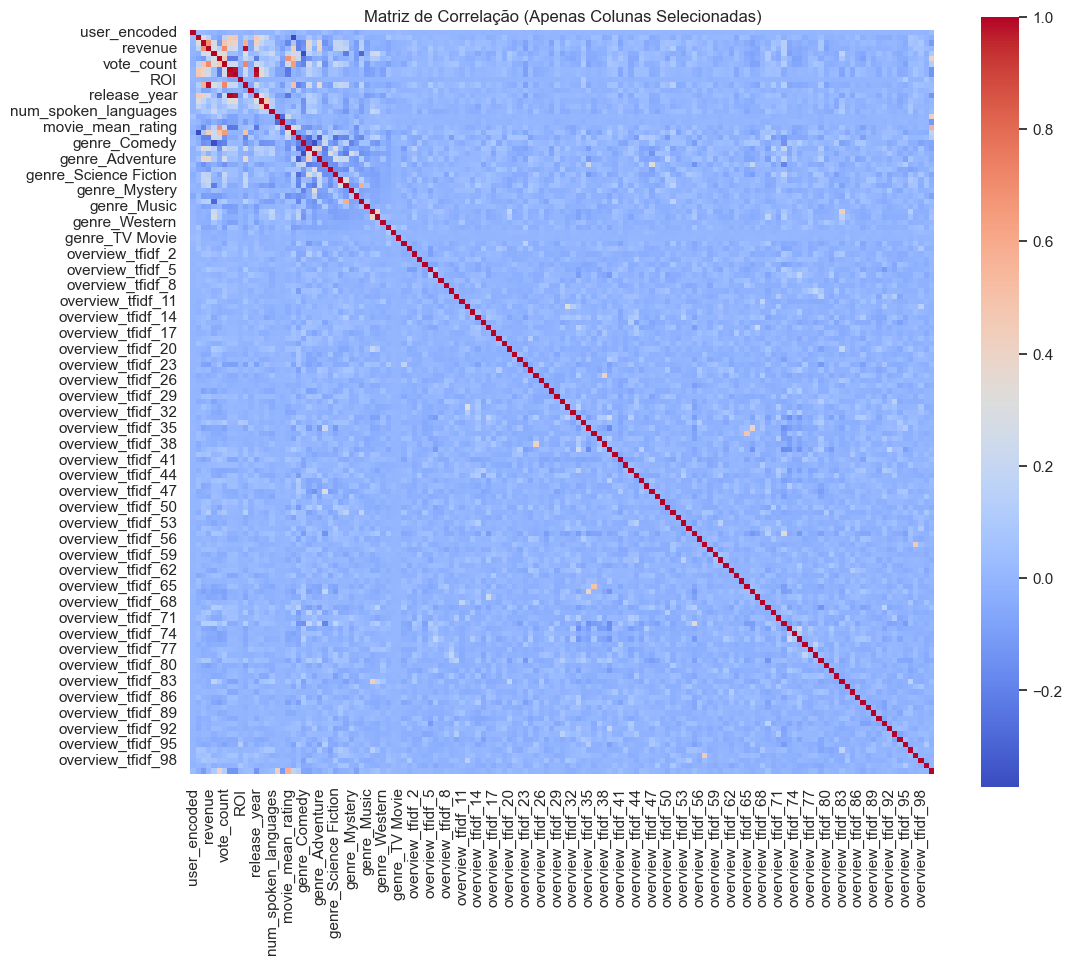

Features altamente correlacionadas com a variável alvo:
 Index(['vote_average', 'user_mean_rating', 'movie_mean_rating', 'rating'], dtype='object')


In [31]:
# Selecionar as colunas de interesse para calcular a matriz de correlação
columns_of_interest = selected_columns + ['rating']  # Adicionar 'rating' para calcular correlação com a variável alvo

# Calcular a matriz de correlação apenas com as colunas de interesse
corr_matrix = data[columns_of_interest].corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Matriz de Correlação (Apenas Colunas Selecionadas)")
plt.show()

# Selecionar features com alta correlação com a variável alvo 'rating'
cor_target = abs(corr_matrix["rating"])
relevant_features = cor_target[cor_target > 0.2].index  # Ajuste o limiar conforme necessário
print("Features altamente correlacionadas com a variável alvo:\n", relevant_features)

# Criar um novo DataFrame contendo apenas as features selecionadas e a variável alvo
data_selected = data[relevant_features]

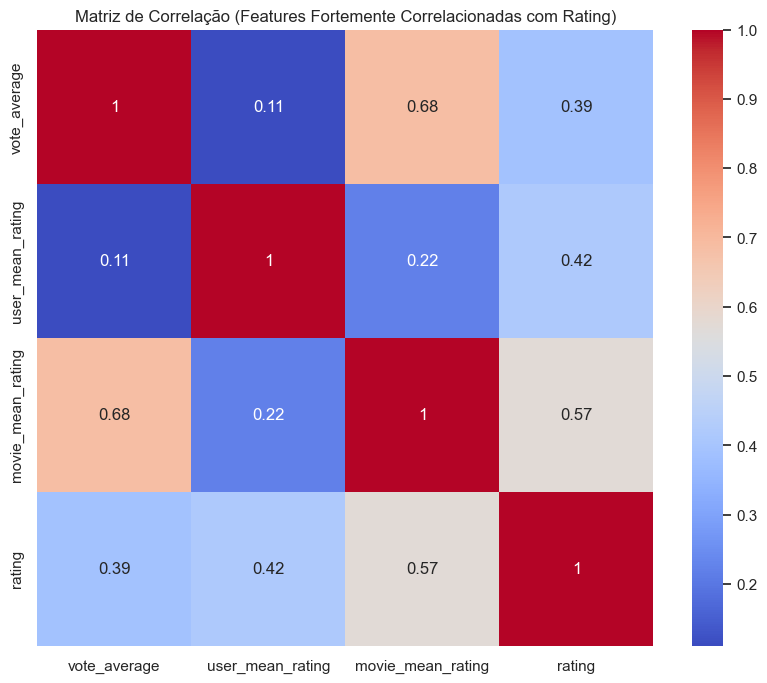

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir o limiar de correlação para exibir apenas features fortemente correlacionadas
correlation_threshold = 0.2  # Ajuste este valor conforme necessário

# Selecionar features com alta correlação (positiva ou negativa) com a variável alvo 'rating'
cor_target = corr_matrix["rating"].abs()  # Obter o valor absoluto da correlação
relevant_features = cor_target[cor_target > correlation_threshold].index  # Somente features fortemente correlacionadas

# Calcular a matriz de correlação apenas com as features relevantes
filtered_corr_matrix = data[relevant_features].corr()

# Visualizar a matriz de correlação filtrada
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Matriz de Correlação (Features Fortemente Correlacionadas com Rating)")
plt.show()


In [34]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import pandas as pd

# Definir número de features a serem exibidas
top_n = 20

# Testar com f_regression
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(data[selected_columns], data['rating'])
scores_f = pd.DataFrame({"Feature": selected_columns, "Score_f_regression": selector_f.scores_})
top_features_f = scores_f.sort_values(by="Score_f_regression", ascending=False).head(top_n)
print(f"Top {top_n} features (f_regression):\n", top_features_f)

# Testar com mutual_info_regression
selector_mi = SelectKBest(score_func=mutual_info_regression, k='all')
selector_mi.fit(data[selected_columns], data['rating'])
scores_mi = pd.DataFrame({"Feature": selected_columns, "Score_mutual_info": selector_mi.scores_})
top_features_mi = scores_mi.sort_values(by="Score_mutual_info", ascending=False).head(top_n)
print(f"\nTop {top_n} features (mutual_info_regression):\n", top_features_mi)

Top 20 features (f_regression):
                    Feature  Score_f_regression
18       movie_mean_rating        24348.022861
16        user_mean_rating        10540.893305
5             vote_average         9067.894311
19      movie_rating_count         1529.517857
6               vote_count          868.031317
12            release_year          864.286389
7                     year          864.286389
8                   decade          837.397743
20             genre_Drama          718.402102
17       user_rating_count          631.454962
2                   budget          545.667557
4                  runtime          475.288366
31            genre_Horror          305.738752
22            genre_Action          287.866748
21            genre_Comedy          231.342156
27   genre_Science Fiction          189.366726
35           genre_History          172.153414
127      overview_tfidf_87          123.137319
109      overview_tfidf_69          117.306840
24         genre_Adventure 

In [35]:
# Combinar os melhores resultados de ambos os métodos
combined_top_features = pd.concat([top_features_f["Feature"], top_features_mi["Feature"]]).unique()
combined_top_features

array(['movie_mean_rating', 'user_mean_rating', 'vote_average',
       'movie_rating_count', 'vote_count', 'release_year', 'year',
       'decade', 'genre_Drama', 'user_rating_count', 'budget', 'runtime',
       'genre_Horror', 'genre_Action', 'genre_Comedy',
       'genre_Science Fiction', 'genre_History', 'overview_tfidf_87',
       'overview_tfidf_69', 'genre_Adventure', 'user_encoded',
       'movie_encoded', 'profit', 'overview_tfidf_72', 'ROI', 'revenue',
       'overview_tfidf_5', 'overview_tfidf_79', 'overview_tfidf_55',
       'overview_tfidf_41', 'overview_tfidf_39', 'overview_tfidf_43',
       'overview_tfidf_94', 'overview_tfidf_58'], dtype=object)

### A partir daqui trabalharemos apenas com os modelos GradientBoost e RandomForest, que foram os que melhor performaram em uma análise preeliminar.

O Random Forest e o Gradient Boosting são modelos ideais para o seu problema de classificação de ratings de filmes, pois ambos capturam relações complexas entre as features de forma robusta e eficaz. O Random Forest é robusto contra overfitting e eficiente para lidar com muitas features, já que ele cria várias árvores independentes, agregando seus resultados. Por outro lado, o Gradient Boosting é especialmente eficaz em entender relações sutis entre as features, pois ajusta sucessivamente os erros das predições anteriores, criando um modelo mais refinado e sensível a pequenas variações nos dados.

In [36]:
# Converter y para categorias com base nos intervalos especificados
def categorize_rating(rating):
    if 0.5 <= rating < 2:
        return 'ruim'
    elif 2 <= rating < 3.5:
        return 'médio'
    elif 3.5 <= rating <= 5:
        return 'bom'
    else:
        return 'indefinido'   # Para garantir que todas as notas sejam categorizadas

In [39]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.feature_selection import RFE, RFECV
# from sklearn.model_selection import StratifiedKFold

# # Certifique-se de que `X` e `y_classes` estão definidos
# # Se `selected_columns` contém as features selecionadas, então:
# X = data[selected_columns]  # Substitua `selected_columns` pelas colunas que deseja usar
# y_classes = np.array([categorize_rating(r) for r in data['rating']])  # Certifique-se de que `y_classes` está definido

# # Remover instâncias 'indefinido' se existirem
# valid_indices = y_classes != 'indefinido'
# X = X[valid_indices]
# y_classes = y_classes[valid_indices]

# # Definir o número mínimo de features para seleção
# min_features_to_select = 10  # Ajuste conforme necessário

# # Modelos para RFE e RFECV
# models = {
#     "Random Forest": RandomForestClassifier(random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42)
# }

# # Dicionário para armazenar as features selecionadas por cada método
# selected_features = {}

# # Loop pelos modelos
# for model_name, model in models.items():
#     print(f"\nAplicando RFE e RFECV com {model_name}...")
    
#     # RFE com um número fixo de features
#     rfe = RFE(estimator=model, n_features_to_select=min_features_to_select, step=1)
#     rfe.fit(X, y_classes)
#     selected_features_rfe = [feature for feature, selected in zip(X.columns, rfe.support_) if selected]
#     print(f"Features selecionadas pelo RFE com {model_name} ({len(selected_features_rfe)} features):")
#     print(selected_features_rfe)
    
#     # RFECV para determinar o número ótimo de features
#     rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', min_features_to_select=min_features_to_select, n_jobs=-1)
#     rfecv.fit(X, y_classes)
#     selected_features_rfecv = [feature for feature, selected in zip(X.columns, rfecv.support_) if selected]
    
#     print(f"\nNúmero ótimo de features pelo RFECV com {model_name}: {rfecv.n_features_}")
#     print(f"Features selecionadas pelo RFECV com {model_name} ({len(selected_features_rfecv)} features):")
#     print(selected_features_rfecv)
    
#     # Armazenar os resultados
#     selected_features[model_name] = {
#         'RFE': selected_features_rfe,
#         'RFECV': selected_features_rfecv
#     }



Aplicando RFE e RFECV com Random Forest...


c:\Users\Eric\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\Eric\anaconda3\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\Eric\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\Eric\anaconda3\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\Eric\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\Eric\anaconda3\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\Eric\anaconda3\Lib\site-packages\executi

KeyboardInterrupt: 

In [2]:
# from sklearn_relief import ReliefF

# # Converter colunas categóricas para numéricas, se houver
# data_numeric = data[selected_columns].copy()
# data_numeric = pd.get_dummies(data_numeric, drop_first=True)

# # Aplicar o ReliefF
# relief = ReliefF()
# relief.fit(data_numeric, data['rating'])

# # Extrair as features selecionadas
# selected_relief_features = [data_numeric.columns[i] for i in range(len(data_numeric.columns)) if relief.w_[i] > 0]
# print("Features selecionadas pelo ReliefF:", selected_relief_features)

NameError: name 'data' is not defined

In [37]:
features = combined_top_features

In [38]:
X = data[features]
y = data['rating']


In [39]:
# Verificar se 'features' está definido
print("Features selecionadas:")
print(features)

# Verificar as formas de X e y
print("\nForma de X:", X.shape)
print("Forma de y:", y.shape)

Features selecionadas:
['movie_mean_rating' 'user_mean_rating' 'vote_average'
 'movie_rating_count' 'vote_count' 'release_year' 'year' 'decade'
 'genre_Drama' 'user_rating_count' 'budget' 'runtime' 'genre_Horror'
 'genre_Action' 'genre_Comedy' 'genre_Science Fiction' 'genre_History'
 'overview_tfidf_87' 'overview_tfidf_69' 'genre_Adventure' 'user_encoded'
 'movie_encoded' 'profit' 'overview_tfidf_72' 'ROI' 'revenue'
 'overview_tfidf_5' 'overview_tfidf_79' 'overview_tfidf_55'
 'overview_tfidf_41' 'overview_tfidf_39' 'overview_tfidf_43'
 'overview_tfidf_94' 'overview_tfidf_58']

Forma de X: (49941, 34)
Forma de y: (49941,)


In [40]:
# Verificar se 'features' está definido
print("Features selecionadas:")
print(features)
print(len(features))

# Verificar as formas de X e y
print("\nForma de X:", X.shape)
print("Forma de y:", y.shape)

Features selecionadas:
['movie_mean_rating' 'user_mean_rating' 'vote_average'
 'movie_rating_count' 'vote_count' 'release_year' 'year' 'decade'
 'genre_Drama' 'user_rating_count' 'budget' 'runtime' 'genre_Horror'
 'genre_Action' 'genre_Comedy' 'genre_Science Fiction' 'genre_History'
 'overview_tfidf_87' 'overview_tfidf_69' 'genre_Adventure' 'user_encoded'
 'movie_encoded' 'profit' 'overview_tfidf_72' 'ROI' 'revenue'
 'overview_tfidf_5' 'overview_tfidf_79' 'overview_tfidf_55'
 'overview_tfidf_41' 'overview_tfidf_39' 'overview_tfidf_43'
 'overview_tfidf_94' 'overview_tfidf_58']
34

Forma de X: (49941, 34)
Forma de y: (49941,)


In [41]:
# Aplicar a função de categorização
y_classes = np.array([categorize_rating(r) for r in y])

# Verificar as classes únicas
print("\nClasses únicas em y_classes:", np.unique(y_classes))

# Remover possíveis instâncias 'indefinido' se existirem
valid_indices = y_classes != 'indefinido'
X = X[valid_indices]
y_classes = y_classes[valid_indices]

# Divisão treino-teste (80% treino, 20% teste) com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y_classes, test_size=0.2, random_state=42, stratify=y_classes
)

print("\nDados divididos:")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")


Classes únicas em y_classes: ['bom' 'médio' 'ruim']

Dados divididos:
Treino: (39952, 34), Teste: (9989, 34)


In [42]:
# Verificar a distribuição das classes no treino e teste
train_class_counts = pd.Series(y_train).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()
print("\nDistribuição das classes no treino:")
print(train_class_counts)
print("\nDistribuição das classes no teste:")
print(test_class_counts)


Distribuição das classes no treino:
bom      26046
médio    11691
ruim      2215
Name: count, dtype: int64

Distribuição das classes no teste:
bom      6512
médio    2923
ruim      554
Name: count, dtype: int64


In [43]:
# Definir o modelo base
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [44]:
# Definir o espaço de hiperparâmetros para a busca em grade
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}

In [46]:
# Métricas de avaliação
metrics = {
    'accuracy': accuracy_score,
    'f1_score': f1_score,
    'recall': recall_score
}

# Resultados
results = []

# Testar cada modelo com busca de hiperparâmetros
for model_name, model in models.items():
    print(f"\nTreinando modelo: {model_name}")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=StratifiedKFold(n_splits=10),
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=0
    )


    # Rodar o GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calcular as métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Exibir os resultados
    print(f"\nResultados para {model_name}:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nMatriz de Confusão:")
    plt.figure(figsize=(8, 6))

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Criar um heatmap da matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    
    # Adicionar títulos e rótulos
    plt.title('Matriz de Confusão')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Prevista')
    
    # Exibir o gráfico
    plt.show()
    
    # Armazenar os resultados
    results.append({
        'model': model_name,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall
    })

# Comparar os resultados de todos os modelos
results_df = pd.DataFrame(results)
print("\nComparação de Desempenho entre Modelos:")
print(results_df)



Treinando modelo: Random Forest


KeyboardInterrupt: 